In [1]:
import matplotlib.image as mpimg
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
import cv2
#import zipfile
from PIL import Image
  
from keras.callbacks import EarlyStopping
#from keras.preprocessing import image_dataset_from_directory
#from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import layers
from tensorflow import keras
#from layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
#from zipfile import ZipFile
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
#accesing path for dataset
data_path='c:\\ZHAW\\23FS\\KI\\DataForProject'
train_path='c:\\ZHAW\\23FS\\KI\\DataForProject\\Train'

#Variables for resizing
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

#Getting Total Nr of Classes from Train Folder
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [3]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = train_path + "\\" + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '\\' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_test = X_train
y_test = y_train

X_train = X_train.astype(np.float32) 
X_valid = X_valid.astype(np.float32) 
X_test = X_test.astype(np.float32) 

In [6]:
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

print("X_train Type:", X_train.dtype)
print("X_valid Type", X_valid.dtype)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
X_test.shape (27446, 30, 30, 3)
y_test.shape (27446,)
X_train Type: float32
X_valid Type float32


In [7]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CATEGORIES)

print(y_train.shape)
print(y_valid.shape)

(27446, 43)
(11763, 43)


In [8]:
#Creating data augementation layers
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.5),
  layers.RandomZoom(.5, .2)
])

In [9]:
input_shape = (30, 30, 3)

model = Sequential()

# Data augmentation layer
data_augmentation = keras.layers.experimental.preprocessing.RandomRotation(0.1)
model.add(data_augmentation)

# Convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [13]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
858/858 [==============================] - 36s 40ms/step - loss: 2.5647 - accuracy: 0.3270 - f1_m: 0.2515 - precision_m: 0.5787 - recall_m: 0.1700 - val_loss: 0.9153 - val_accuracy: 0.7341 - val_f1_m: 0.6384 - val_precision_m: 0.9344 - val_recall_m: 0.4899
Epoch 2/15
858/858 [==============================] - 41s 48ms/step - loss: 1.0747 - accuracy: 0.6634 - f1_m: 0.6379 - precision_m: 0.8284 - recall_m: 0.5269 - val_loss: 0.2998 - val_accuracy: 0.9099 - val_f1_m: 0.9040 - val_precision_m: 0.9531 - val_recall_m: 0.8611
Epoch 3/15
858/858 [==============================] - 39s 45ms/step - loss: 0.6953 - accuracy: 0.7840 - f1_m: 0.7784 - precision_m: 0.8681 - recall_m: 0.7086 - val_loss: 0.1733 - val_accuracy: 0.9592 - val_f1_m: 0.9535 - val_precision_m: 0.9802 - val_recall_m: 0.9289
Epoch 4/15
858/858 [==============================] - 38s 44ms/step - loss: 0.5041 - accuracy: 0.8417 - f1_m: 0.8409 - precision_m: 0.8945 - recall_m: 0.7953 - val_loss: 0.0948 - val_accuracy: 0.9

In [14]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=0)

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_train, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred_bool))

429/429 [==============================] - 5s 10ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

train_pred = model.predict(X_train)
train_predicted = np.argmax(train_pred, axis=1)

plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, train_predicted,
                                        normalize="true", values_format=".0%")
plt.show()


test_pred = model.predict(X_test)
test_predicted = np.argmax(test_pred, axis=1)
ConfusionMatrixDisplay.from_predictions(y_test, test_predicted,
                                        normalize="true", values_format=".0%")
plt.show()

858/858 [==============================] - 5s 6ms/step


ValueError: Mix type of y not allowed, got types {'multiclass', 'multilabel-indicator'}

In [19]:
# show image that were classified incorectly
cl_a, cl_b = 0, 6
X_aa = X_train[np.intersect1d(np.where(y_train == cl_a)[0], np.where(train_predicted == cl_a)[0])]
X_ab = X_train[np.intersect1d(np.where(y_train == cl_a)[0], np.where(train_predicted == cl_b)[0])]
X_ba = X_train[np.intersect1d(np.where(y_train == cl_b)[0], np.where(train_predicted == cl_a)[0])]
X_bb = X_train[np.intersect1d(np.where(y_train == cl_b)[0], np.where(train_predicted == cl_b)[0])]

NameError: name 'train_predicted' is not defined

In [18]:
#
plt.figure(0)
plt.plot(history.history[precision_m],label='training accuracy')
plt.plot(history.history[val_precision_m],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

KeyError: <function precision_m at 0x000001A47945AAF0>

<Figure size 432x288 with 0 Axes>

<function matplotlib.pyplot.show(close=None, block=None)>

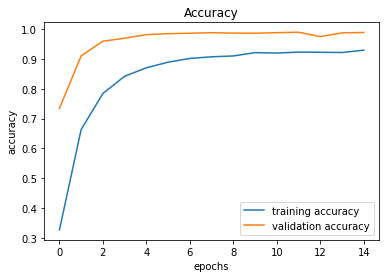

In [15]:
#accuracy
plt.figure(0)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

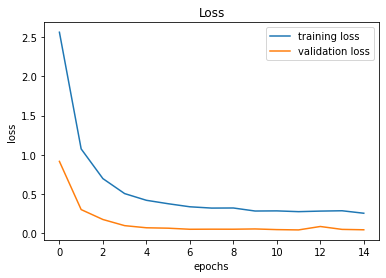

In [16]:
#Loss
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show